# Quantum Process Tomography with Q# and Python #

## Abstract ##

In this sample, we will demonstrate interoperability between Q# and Python by using the QInfer and QuTiP libraries for Python to characterize and verify quantum processes implemented in Q#.
In particular, this sample will use *quantum process tomography* to learn about the behavior of a "noisy" Hadamard operation from the results of random Pauli measurements.

## Preamble ##

In [1]:
import warnings
warnings.simplefilter('ignore')

We can enable Q# support in Python by importing the `qsharp` package.

In [2]:
import qsharp 

Once we do so, any Q# source files in the current working directory are compiled, and their namespaces are made available as Python modules.
For instance, the `Operation.qs` source file provided with this sample implements a `HelloWorld` operation in the `Microsoft.Quantum.Samples.Python` Q# namespace:

In [3]:
with open('Operation.qs') as f:
    print(f.read())

// Copyright (c) Microsoft Corporation. All rights reserved.
// Licensed under the MIT License.
namespace Microsoft.Quantum.Samples.Python {
    open Microsoft.Quantum.Primitive;
    open Microsoft.Quantum.Canon;

    function HelloWorld (pauli : Pauli) : Unit {
        Message($"Hello, world! {pauli}");
    }

    operation NoisyHadamardChannelImpl (depol : Double, target : Qubit) : Unit {
        let idxAction = Random([1.0 - depol, depol]);

        if (idxAction == 0) {
            H(target);
        }
        else {
            PrepareSingleQubitIdentity(target);
        }
    }

    function NoisyHadamardChannel (depol : Double) : (Qubit => Unit) {
        return NoisyHadamardChannelImpl(depol, _);
    }

}





We can import this `HelloWorld` operation as though it was an ordinary Python function by using the Q# namespace as a Python module:

In [4]:
from Microsoft.Quantum.Samples.Python import HelloWorld

In [5]:
HelloWorld

<Q# callable Microsoft.Quantum.Samples.Python.HelloWorld>

Once we've imported the new names, we can then ask our simulator to run each function and operation using the `simulate` method.

In [6]:
HelloWorld.simulate(pauli=qsharp.Pauli.Z)

Hello, world! PauliZ


()

## Tomography ##

The `qsharp` interoperability package also comes with a `single_qubit_process_tomography` function which uses the QInfer library for Python to learn the channels corresponding to single-qubit Q# operations.

In [7]:
from qsharp.tomography import single_qubit_process_tomography

Next, we import plotting support and the QuTiP library, since these will be helpful to us in manipulating the quantum objects returned by the quantum process tomography functionality that we call later.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
import qutip as qt
qt.settings.colorblind_safe = True

To use this, we define a new operation that takes a preparation and a measurement, then returns the result of performing that tomographic measurement on the noisy Hadamard operation that we defined in `Operation.qs`.

In [10]:
experiment = qsharp.compile("""
open Microsoft.Quantum.Samples.Python;

operation Experiment(prep : Pauli, meas : Pauli) : Result {
    return SingleQubitProcessTomographyMeasurement(prep, meas, NoisyHadamardChannel(0.1));
}
""")

Here, we ask for 10,000 measurements from the noisy Hadamard operation that we defined above.

In [11]:
estimation_results = single_qubit_process_tomography(experiment, n_measurements=10000)

Preparing tomography model...
Performing tomography...


To visualize the results, it's helpful to compare to the actual channel, which we can find exactly in QuTiP.

In [12]:
depolarizing_channel = sum(map(qt.to_super, [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()])) / 4.0
actual_noisy_h = 0.1 * qt.to_choi(depolarizing_channel) + 0.9 * qt.to_choi(qt.hadamard_transform())

We then plot the estimated and actual channels as Hinton diagrams, showing how each acts on the Pauli operators $X$, $Y$ and $Z$.

(None, <matplotlib.axes._subplots.AxesSubplot at 0x1dfe7176a20>)

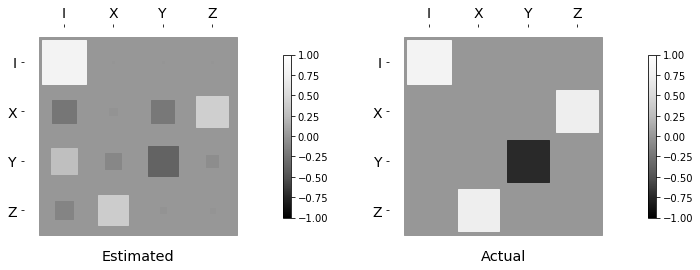

In [13]:
fig, (left, right) = plt.subplots(ncols=2, figsize=(12, 4))
plt.sca(left)
plt.xlabel('Estimated', fontsize='x-large')
qt.visualization.hinton(estimation_results['est_channel'], ax=left)
plt.sca(right)
plt.xlabel('Actual', fontsize='x-large')
qt.visualization.hinton(actual_noisy_h, ax=right)

We also obtain a wealth of other information as well, such as the covariance matrix over each parameter of the resulting channel.
This shows us which parameters we are least certain about, as well as how those parameters are correlated with each other.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

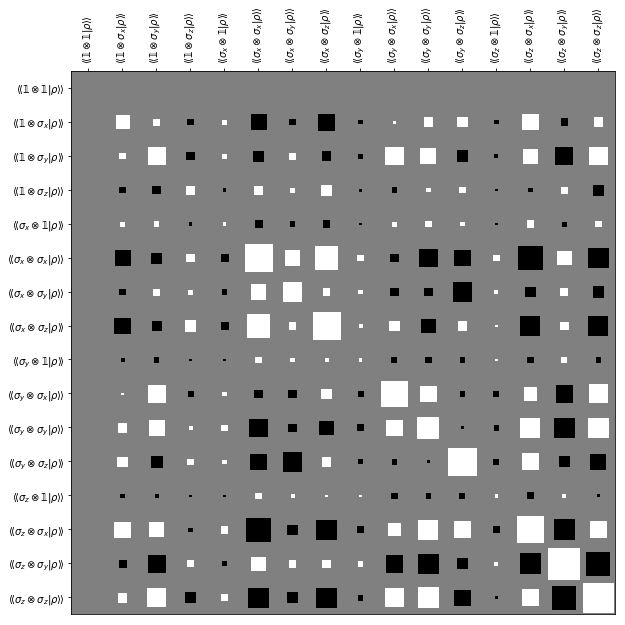

In [14]:
plt.figure(figsize=(10, 10))
estimation_results['posterior'].plot_covariance()
plt.xticks(rotation=90)

## Diagnostics ##

In [15]:
for component, version in sorted(qsharp.component_versions().items(), key=lambda x: x[0]):
    print(f"{component:20}{version}")

Jupyter Core        1.1.12077.0
iqsharp             0.5.1903.2902
qsharp              0.5.1903.2902


In [16]:
import sys
print(sys.version)

3.6.7 (default, Feb 28 2019, 07:28:18) [MSC v.1900 64 bit (AMD64)]
